In [1]:
from qualibrate import QualibrationNode
from quam_libs.macros import T1_extraction
import numpy as np

2026-02-13 14:52:09,230 - qm - INFO     - Starting session: e1c2bce2-29f1-46c5-93bc-2a6a1f2bf051


In [2]:
node  = QualibrationNode(name="quantum_memory_dephasing")

2026-02-13 14:52:24,454 - qualibrate - INFO - Creating node quantum_memory_dephasing


In [3]:
# plotting data structure

dephasing_T2_data = {
    'raw':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'mle':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2':{
        't2':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2_detuning':{
    't2':[],
    'axes':{'original':[], 'fit':[]},
    'volume':{'original':[], 'fit':[]},
    'negativity':{'original':[], 'fit':[]},
    }
}

In [4]:
from pathlib import Path
data_path = Path('/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/data/Markovian')


In [5]:
# T1 and T2 data

T1_mean, T1_std, T2_mean, T2_std = [], [], [], []
T1_experiment_index = [1274,1283,1292,1301,1310,1319,1328,1337,1346,1355,1364,1381,1390,1399,1409,1418,1427,1445,1436,1454,1466]
T2_experiment_index = [1276,1285,1294,1303,1312,1321,1330,1339,1348,1357,1366,1383,1392,1401,1411,1420,1429,1447,1438,1456,1467]

for T1_index, T2_index in zip(T1_experiment_index, T2_experiment_index):
    node_T1_ds = node.load_from_id(T1_index, base_path=data_path).results['ds']
    mean, std = T1_extraction(node_T1_ds)
    T1_mean.append(mean)
    T1_std.append(std)
    
    node_T2 = node.load_from_id(T2_index, base_path=data_path)
    T2_mean.append(node_T2.results['fit_results']['q0']['decay'])
    T2_std.append(node_T2.results['fit_results']['q0']['decay_error'])


In [6]:
# ellipsoid data 

dephasing_experiment_index = [1497,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1516,1515,1517,1518]
dephasing_voltage = [0,5,10,20,30,40,50,60,70,75,80,85,90,95,100,105,110,115,120,125,130]

dephasing_ds ={
    f'dephasing_voltage={dephasing_voltage[i]}mV':node.load_from_id(dephasing_experiment_index[i],base_path = data_path).results['ds']
    for i in range(len(dephasing_voltage))
}
dephasing_key = dephasing_ds.keys()

In [7]:
from quam_libs.QI_utils import bloch_vector_to_density_matrix
from quam_libs.analyzer import QuantumMemoryAnalyze, EllipsoidFitParameters

fit_params = EllipsoidFitParameters(
    filter_method="convex",      # "none" | "convex" | "ransac"
    correct_rotation_orientation=True,
    # ransac_threshold=0.01,
    # ransac_iterations=1500,
    # random_state=None,
)

In [8]:
dephasing_data = {}
dephasing_analyze={}
do_convex_hull = True
for i, key in enumerate(dephasing_key):
    ds = dephasing_ds[key]
    data_xyz = np.array([[ds.Bloch_vector_x.values[0][i], ds.Bloch_vector_y.values[0][i], ds.Bloch_vector_z.values[0][i]] for i in range(len(ds.n_points.values))])
    data_angle = np.array([[ds.theta.values[i], ds.phi.values[i]] for i in range(len(ds.n_points.values))])
    data_dm = np.array([bloch_vector_to_density_matrix(data_xyz[i]) for i in range(len(data_xyz))])

    noise_analyzer = QuantumMemoryAnalyze(data_xyz,data_angle,fit_params)
    corrected_dm = noise_analyzer.corrected_dm
    corrected_bloch = noise_analyzer.corrected_bloch
    ellipsoid_results = noise_analyzer.ellipsoid_fit_results()
    dephasing_data[key] = {
        "qubit_properties":{
            "t1":T1_mean[i],
            "t1_std":T1_std[i],
            "t2":T2_mean[i],
            "t2_std":T2_std[i],
            "dephasing_rate":1/T2_mean[i] - 1/(2*T1_mean[i]),
        },
        'data':{
            'original_xyz': data_xyz,
            'original_dm' :data_dm,
            'angle': data_angle,
            'corrected_xyz': corrected_bloch,
            'corrected_dm': corrected_dm
        },
        'ellipsoid':{
            'axes':ellipsoid_results['axes'],
            'center':ellipsoid_results['center'],
            'volume':ellipsoid_results['volume'],
            'param':ellipsoid_results['fit_param'],
            "rotation_matrix":ellipsoid_results['rotation_matrix'],
        },
        "quantum_information":{
            "choi":noise_analyzer.choi,
            "robustness":noise_analyzer.memory_robustness
        }
    }
    dephasing_analyze[key] = noise_analyzer

/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:41: UserWarning: The problem has an expression with dimension greater than 2. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


In [9]:
robust  = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]
T2 = [dephasing_data[key]['qubit_properties']['t2'] for key in dephasing_data.keys()]

In [10]:
for key in dephasing_data.keys():
    print(f"{key}: rotation matrxis = \n{dephasing_data[key]['ellipsoid']['rotation_matrix']}\n")
    print(f"determinant = {np.linalg.det(dephasing_data[key]['ellipsoid']['rotation_matrix'])}\n")

dephasing_voltage=0mV: rotation matrxis = 
[[-0.71364824 -0.69546208 -0.08389684]
 [-0.69050793  0.67824002  0.25137478]
 [ 0.11791943 -0.2373246   0.96424688]]

determinant = -1.0

dephasing_voltage=5mV: rotation matrxis = 
[[-0.72664888 -0.6868923   0.01266354]
 [-0.67623753  0.71838565  0.16317124]
 [ 0.12117838 -0.11000464  0.98651649]]

determinant = -1.0

dephasing_voltage=10mV: rotation matrxis = 
[[ 0.66748128  0.74060149  0.07731865]
 [ 0.71924823 -0.61436946 -0.32439506]
 [ 0.19274525 -0.27213893  0.94275642]]

determinant = -0.9999999999999998

dephasing_voltage=20mV: rotation matrxis = 
[[-0.81944865 -0.57310537 -0.00735838]
 [-0.56695266  0.80863439  0.1570831 ]
 [ 0.08407493 -0.13289339  0.98755797]]

determinant = -0.9999999999999997

dephasing_voltage=30mV: rotation matrxis = 
[[ 0.81294486  0.58230259 -0.00665986]
 [ 0.51186726 -0.71997104 -0.46865083]
 [ 0.2776915  -0.37757832  0.88335839]]

determinant = -1.0000000000000002

dephasing_voltage=40mV: rotation matrxis =

In [11]:
axes_list = [dephasing_data[key]['ellipsoid']['axes'] for key in dephasing_data.keys()]
volume_list = [dephasing_data[key]['ellipsoid']['volume'] for key in dephasing_data.keys()]
robust_list = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]

/var/folders/0n/zdq18xnd4cdby_1m6mnmrwn40000gn/T/ipykernel_25971/2320310752.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


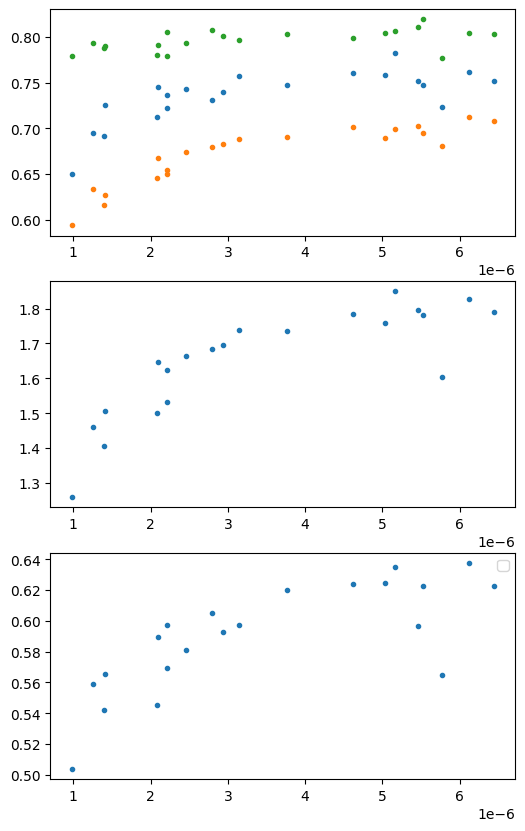

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,10))
ax_axes = fig.add_subplot(311)
ax_volume = fig.add_subplot(312)
ax_robustness = fig.add_subplot(313)
ax_axes.plot(T2, [axes[0] for axes in axes_list], '.',label='x')
ax_axes.plot(T2, [axes[1] for axes in axes_list], '.',label='y')
ax_axes.plot(T2, [axes[2] for axes in axes_list], '.',label='z')

ax_volume.plot(T2, volume_list, '.')
ax_robustness.plot(T2, robust_list, '.')
plt.legend()



In [11]:
%matplotlib inline
figure_list = []
for key in Noise_data.keys():
    if False:
        a = Noise_analyze[key].ellipsoid_plot(title=key)
        figure_list.append(a)